In [85]:
from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [86]:

!pip install pyprind


In [0]:
import pandas as pd

from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer

import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
import glob
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
#from keras.preprocessing.text import Tokenizer



In [0]:
from keras import layers
from keras.layers import Dropout

In [0]:
import os
os.chdir('/content/drive/My Drive/CA684_Assignment/')

In [0]:
# for reproducability
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [0]:
# load labels and captions
# Function to load the captions into dataframes
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt'
df_cap = read_caps(cap_path)

# load the ground truth values

labels = pd.read_csv('/content/drive/My Drive/CA684_Assignment/Dev-set/Ground-truth/ground-truth.csv')

In [93]:
print(df_cap)

               video                                            caption
0        video3.webm                 blonde-woman-is-massaged-tilt-down
1        video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2        video6.webm                                      khr-gangsters
3        video8.webm               medical-helicopter-hovers-at-airport
4       video10.webm               couple-relaxing-on-picnic-crane-shot
...              ...                                                ...
5995  video7488.webm        beautiful-young-woman-in-front-of-fountains
5996  video7489.webm  focus-pull-from-molting-penguin-to-penguin-col...
5997  video7491.webm           students-walking-in-university-of-mexico
5998  video7492.webm                       beautiful-black-woman-at-spa
5999  video7493.webm  beautiful-modern-brunette-woman-using-tablet-c...

[6000 rows x 2 columns]


In [94]:
df_cap.head()



,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [95]:
df_cap['video'].head()

0     video3.webm
1     video4.webm
2     video6.webm
3     video8.webm
4    video10.webm
Name: video, dtype: object

In [96]:
print(labels)

               video  ...  nb_long-term_annotations
0        video3.webm  ...                        13
1        video4.webm  ...                        12
2        video6.webm  ...                        10
3        video8.webm  ...                        11
4       video10.webm  ...                        10
...              ...  ...                       ...
5995  video7488.webm  ...                         9
5996  video7489.webm  ...                        31
5997  video7491.webm  ...                        11
5998  video7492.webm  ...                        16
5999  video7493.webm  ...                        13

[6000 rows x 5 columns]


In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [0]:
#Function_load C3D features
def load_c3d(captions, c3dPath):
    files_list = list(captions["video"].values)
    c3dfeatures = []
    for file in files_list:
        file = c3dPath+file[:-4]+'txt'
        c3dfeatures.append(np.loadtxt(file))
    #print(type(c3dfeatures))
    return c3dfeatures

In [0]:
#load C3D features
c3dPath = '/content/drive/My Drive/CA684_Assignment/Dev-set/C3D'


In [100]:
#merging the captions and ground thruth values
df_merge = df_cap.merge(labels,on=["video"],how="inner")
df_merge

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12
2,video6.webm,khr-gangsters,0.863,33,0.700,10
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10
...,...,...,...,...,...,...
5995,video7488.webm,beautiful-young-woman-in-front-of-fountains,0.921,33,1.000,9
5996,video7489.webm,focus-pull-from-molting-penguin-to-penguin-col...,0.909,53,0.839,31
5997,video7491.webm,students-walking-in-university-of-mexico,0.713,33,0.818,11
5998,video7492.webm,beautiful-black-woman-at-spa,0.954,34,1.000,16


In [101]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:

#function to remove punctuation
def punct_remove(text):
  nopunct_text="".join([char for char in text if char not in string.punctuation])  #it will discard all punctuation
  return nopunct_text

In [103]:
df_merge['body_text_clean']=df_merge['caption'].apply(lambda x: punct_remove(x))
df_merge.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,body_text_clean
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13,blondewomanismassagedtiltdown
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12,roulettetablespinningwithballincloseupshot
2,video6.webm,khr-gangsters,0.863,33,0.700,10,khrgangsters
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11,medicalhelicopterhoversatairport
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10,couplerelaxingonpicniccraneshot


In [104]:
import re

#function to tokenise

def fn_tokenize(text):
  tokens1=re.split('\W+',text)
  return tokens1
df_merge['tokenized_body']=df_merge['caption'].apply(lambda x: fn_tokenize(x.lower()))
df_merge.head()

,video,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,body_text_clean,tokenized_body
0,video3.webm,blonde-woman-is-massaged-tilt-down,0.924,34,0.846,13,blondewomanismassagedtiltdown,"[blonde, woman, is, massaged, tilt, down]"
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot,0.923,33,0.667,12,roulettetablespinningwithballincloseupshot,"[roulette, table, spinning, with, ball, in, cl..."
2,video6.webm,khr-gangsters,0.863,33,0.700,10,khrgangsters,"[khr, gangsters]"
3,video8.webm,medical-helicopter-hovers-at-airport,0.922,33,0.818,11,medicalhelicopterhoversatairport,"[medical, helicopter, hovers, at, airport]"
4,video10.webm,couple-relaxing-on-picnic-crane-shot,0.950,34,0.900,10,couplerelaxingonpicniccraneshot,"[couple, relaxing, on, picnic, crane, shot]"


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer(min_df=1, stop_words='english') # used to remove stopwords

In [106]:
X_counts1=vect.fit_transform(df_merge['caption'])
print(X_counts1.shape)

(6000, 5019)


In [0]:
X_counts1=vect.fit_transform(df_merge['caption'])

In [108]:

X_counts_sequence=X_counts1.toarray()
X_counts_sequence

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [109]:
print(X_counts_sequence[0])

[0 0 0 ... 0 0 0]


Model

In [0]:

Y=df_merge[['short-term_memorability','long-term_memorability']].values  #targets
X=X_counts_sequence #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [112]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 5019)
X_test (1200, 5019)
Y_train (4800, 2)
Y_test (1200, 2)


In [113]:
n_cols = X_train.shape[1]
n_cols

5019

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
# Setting up the model using Sequential model
model = Sequential()
# Add the first layer
model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
# Add the second layer
model.add(layers.Dropout(0.6)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(Dense(32, activation='relu'))
# Add the third layer
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(2))

In [0]:
# Compiling the model
model.compile(optimizer='rmsprop', loss = 'mean_squared_error')

In [116]:
# Verifying that model contains information from compiling
print("Loss function: " + model.loss)

Loss function: mean_squared_error


In [117]:
# Fitting the model
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 1s 186us/step - loss: 0.0853 - val_loss: 0.0142
Epoch 2/20
4800/4800 [==============================] - 1s 167us/step - loss: 0.0141 - val_loss: 0.0134
Epoch 3/20
4800/4800 [==============================] - 1s 169us/step - loss: 0.0130 - val_loss: 0.0133
Epoch 4/20
4800/4800 [==============================] - 1s 167us/step - loss: 0.0124 - val_loss: 0.0132
Epoch 5/20
4800/4800 [==============================] - 1s 172us/step - loss: 0.0117 - val_loss: 0.0134
Epoch 6/20
4800/4800 [==============================] - 1s 170us/step - loss: 0.0113 - val_loss: 0.0137
Epoch 7/20
4800/4800 [==============================] - 1s 171us/step - loss: 0.0108 - val_loss: 0.0143
Epoch 8/20
4800/4800 [==============================] - 1s 170us/step - loss: 0.0104 - val_loss: 0.0141
Epoch 9/20
4800/4800 [==============================] - 1s 169us/step - loss: 0.0099 - val_loss: 0.0139
Epoch 10/20
4800

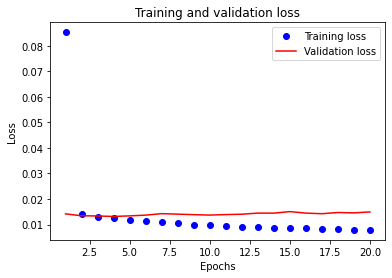

In [118]:
#loss Visualisation
loss_viz = history.history['loss']
val_loss_viz = history.history['val_loss']

epochs = range(1,len(loss_viz)+1)

plt.plot(epochs,loss_viz,'bo',label='Training loss')
plt.plot(epochs,val_loss_viz,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [119]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Calculating Spearman scores which is best if the value is above 0.300

[[0.9143589  0.80135113]
 [0.8945318  0.9056938 ]
 [0.87871975 0.81387633]
 ...
 [0.89208734 0.9006123 ]
 [0.8878455  0.74307877]
 [0.8589348  0.7485948 ]]
The Spearman's correlation coefficient is: 0.401
The Spearman's correlation coefficient is: 0.173


Text(0, 0.5, 'long-term-values')

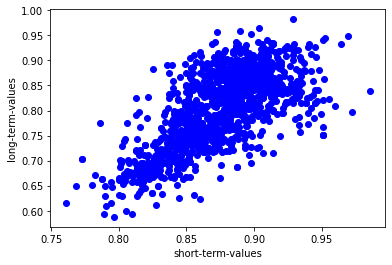

In [120]:
plt.figure()
plt.scatter(predictions[:,0],predictions[:,1],marker='o',c='b')
plt.xlabel('short-term-values')
plt.ylabel('long-term-values')


In [121]:
#loading the nltk stopwords of English
nltk.download('stopwords')
stopword_count = nltk.corpus.stopwords.words('english')
print(f'Length of Stopwords: {len(stopword_count)}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Length of Stopwords: 179


In [122]:
#Removing punctuations and stop words from captions
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #removing stopwords
    rmv_stopwords1= ' '.join([word for word in text.split() if word not in stopword_count])
    df_cap.loc[i,'caption'] = rmv_stopwords1 #updating the original captions 
    pbar.update()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [123]:
df_cap.head()

,video,caption
0,video3.webm,blonde woman massaged tilt
1,video4.webm,roulette table spinning ball closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers airport
4,video10.webm,couple relaxing picnic crane shot


In [158]:
#implementing bag of words for the combined captions
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_select = CountVectorizer(analyzer = "word",max_features=3112) 
captions_bag = vectorizer_select.fit_transform(df_cap.caption).toarray()
type(captions_bag)

numpy.ndarray

In [159]:
#to get the dimensions of the array
captions_bag.shape

(6000, 3112)

SVR with Captions

In [0]:

svr_X = captions_bag
svr_y_short = labels[['short-term_memorability']].values
svr_y_long = labels[['long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [0]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [164]:

from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [166]:

Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.338
The Spearman's correlation coefficient is: 0.170


In [0]:
#Random Forest with captions

In [0]:
X = captions_bag
y = labels[['short-term_memorability','long-term_memorability']].values

In [0]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=43)

In [169]:
print('X_train ', X_train.shape)
print('X_test  ', X_test.shape)
print('Y_train ', y_train.shape)
print('Y_test  ', y_test.shape)

X_train  (4500, 3112)
X_test   (1500, 3112)
Y_train  (4500, 2)
Y_test   (1500, 2)


In [0]:
from sklearn.ensemble import RandomForestRegressor
captions_rf = RandomForestRegressor(n_estimators=100,random_state=45)

In [171]:
captions_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=45, verbose=0, warm_start=False)

In [0]:
captions_pred = captions_rf.predict(X_test)

In [173]:
Get_score(captions_pred, y_test)

The Spearman's correlation coefficient is: 0.404
The Spearman's correlation coefficient is: 0.186


In [0]:
#method to extract hmp features

def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

Importing Test Dataset and Captions

In [0]:



# load the ground truth values -test set
csv_path = '/content/drive/My Drive/CA684_Assignment/Test-set/Ground-truth_test/ground_truth_template.csv'
labels_test = pd.read_csv(csv_path)

In [0]:
# load the captions - test set
cap_path = '/content/drive/My Drive/CA684_Assignment/Test-set/Captions_test/test-set-1_video-captions.txt'
test_captions=read_caps(cap_path)

In [143]:
labels_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [144]:
test_captions.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [145]:
#printing the dimensions of test-set ground thruth dataset and captions test features
print(f'Test-Dataset : {labels_test.shape}')
print(f'Test-Captions: {test_captions.shape}')

Test-Dataset : (2000, 5)
Test-Captions: (2000, 2)


In [146]:
#Removing punctuations and stop words from captions
pbar = pyprind.ProgBar(len(test_captions['caption']), title='Counting word occurrences')
for i, cap in enumerate(test_captions['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    # stopwords removal
    stopwords_rem= ' '.join([word for word in text.split() if word not in stopword_count])
    test_captions.loc[i,'caption'] = stopwords_rem #Original captions updation 
    pbar.update()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [147]:
test_captions.head()

,video,caption
0,video7494.webm,green jeep struggling drive huge rocks
1,video7495.webm,hiking woman tourist walking forward mountains...
2,video7496.webm,close african american doctors hands using sph...
3,video7497.webm,slow motion man using treadmill gym regular ph...
4,video7498.webm,slow motion photographer national park


In [148]:
#For the combined captions bag of words are implemented 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",max_features=3122) 
test_bag_captions = vectorizer.fit_transform(test_captions.caption).toarray()
type(test_bag_captions)

numpy.ndarray

In [149]:
print(f'Development Vocabulary Size   : {len(captions_bag[0])}')
print(f'Testing Vocabulary Size       : {len(test_bag_captions[0])}')

Development Vocabulary Size   : 3112
Testing Vocabulary Size       : 3112


Scores prediction and Exporting the Results

In [0]:
test_pred = captions_rf.predict(test_bag_captions)

In [0]:
pred = pd.DataFrame()

In [152]:
type(test_pred)

numpy.ndarray

In [0]:
pred['short-term'] = test_pred[:,0]

In [0]:
pred['long-term'] = test_pred[:,1]

In [155]:
pred.describe()

,short-term,long-term
count,2000.000000,2000.000000
mean,0.847639,0.745825
std,0.034477,0.066337
min,0.673031,0.470359
25%,0.829784,0.714741
50%,0.851416,0.750103
75%,0.870644,0.785890
max,0.955108,0.951378


In [0]:
pred.to_csv('/content/drive/My Drive/predictions.csv')

In [0]:
model.save('/content/drive/My Drive/my_model.h5')  # creates a HDF5 file 'my_model.h5'